# Imports and downloads

In [ ]:
!pip install NRCLex
!pip install torch
!pip install stanza

In [ ]:
import stanza
stanza.download('en')
import nltk
nltk.download('punkt')
from bs4 import BeautifulSoup
from nrclex import NRCLex
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

2022-05-15 08:04:31 INFO: Downloading default packages for language: en (English)...


2022-05-15 08:04:51 INFO: Finished downloading models and saved to /root/stanza_resources.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Converting Data to JSON

In [ ]:
def get_character_dictionary_from_html(filename, name_position, dialogue_position, scenario_position):
  """
  This function takes the name of the file, the starting position of the name, dialogue,
  and scenario. Then, returns the dictionary.

    Parameters:
      filename: string: The path of the file to read
      name_position: float: The starting value of left pixel for name of character
      dialogue_position: float: The starting value of left pixel for dialogues
      scenario_position: float: The starting value of left pixel for scenarios

    Returns:
      character_dialogues: dict: A dictionary with every character's dialogues,
                               : The sample format is "Name": list of dialogues
      scenarios: dict: A list of scenarios, with the key "scenarios". It is kept
                      as a dict because we can further classify it into different
                      kinds of scenarios if we want
  """
  with open(filename) as fp:
      soup = BeautifulSoup(fp, "html.parser")

  everything = soup.find_all('div')
  character_dialogues = {}
  character = ""
  scenarios = {'scenarios': []} 
  dialogue = "" 
  dialogue_ready = False
  for div in everything:
    try:
      if float(div['style'].split(';')[1].split(':')[1].split('px')[0]) >= name_position-5 \
       and float(div['style'].split(';')[1].split(':')[1].split('px')[0]) <= name_position+5:
        if dialogue_ready:  # For the first dialogue
          if not character_dialogues.get(character):
            character_dialogues[character] = []
          character_dialogues[character].append(dialogue)
          dialogue = ""
        character = div.text  # Character updated
      if float(div['style'].split(';')[1].split(':')[1].split('px')[0]) >= dialogue_position-5 \
       and float(div['style'].split(';')[1].split(':')[1].split('px')[0]) <= dialogue_position+5:
        dialogue = dialogue + " " + div.text
        dialogue_ready = True
      if float(div['style'].split(';')[1].split(':')[1].split('px')[0]) >= scenario_position-5 \
       and float(div['style'].split(';')[1].split(':')[1].split('px')[0]) <= scenario_position+5:
        scenarios['scenarios'].append(div.text)
    except:
      pass
    
  if not character_dialogues.get(character):
    character_dialogues[character] = []
  character_dialogues[character].append(dialogue)
  dialogue = ""

  return character_dialogues, scenarios

In [ ]:
def get_character_dictionary_from_text(filename, name_position, dialogue_position, scenario_position):
  """
  This function converts a text file inot a character dictionary.

    Parameters:
      filename: string: The path of the file to read
      name_position: int: Number of spaces before the name
      dialogue_position: int: Number of spaces before the dialogues
      scenario_position: int: Number of spaces before the scenarios

    Returns:
      character_dialogues: dict: A dictionary with every character's dialogues,
                               : The sample format is "Name": list of dialogues
      scenarios: dict: A list of scenarios, with the key "scenarios". It is kept
                      as a dict because we can further classify it into different
                      kinds of scenarios if we want
  """
  # Filtering the empty lines
  lines = list(filter(lambda x: x!='', open(filename).read().split('\n')))
  character_dialogues = {}
  scenarios = {'scenarios': []} 
  dialogue = "" 
  dialogue_ready = False
  for line in lines:  # for every line
    line_arr = line.split(":") 
    if len(line_arr) == 1:
      scenarios['scenarios'].append(line_arr[0])
    elif len(line_arr) == 2:
      character = line_arr[0]
      dialogue = line_arr[1]
      # If some random line is classified as a dialogue, skip it; 
      if len(character) >= 30:
        continue
      if not character_dialogues.get(character):
          character_dialogues[character] = []
      character_dialogues[character].append(dialogue)
  return character_dialogues, scenarios

In [ ]:
"""
A driver function showing how everything characters are being converted
"""
character_dialogues, scenarios = get_character_dictionary_from_html("the-shawshank-redemption-1994.html", 252, 180, 108 )
import json
with open('the-shawshank-redemption-1994.json', 'w') as fp:
    json.dump(character_dialogues, fp)

with open('the-shawshank-redemption-1994_scenario.json', 'w') as fp:
    json.dump(scenarios, fp)

# Pre processing and finding gender

In [ ]:
def process(name):
  """
  Takes a name and remove anything written in brackets
  """
  final_name = ''
  names = name.split(' ')
  for n in names:
    if len(n)==0:
      continue
    if n[0] == '(':
      break
    final_name += n + ' '
  return final_name.strip()

# Taking unique characters only, and dropping characters that have less than 10 values
names_of_characters = list(set([(process(i), len(character_dialogues[i])) for i in character_dialogues.keys()]))
names_of_characters = list(set([ i for i, j in names_of_characters if j>= 10]))
names_of_characters

In [ ]:
"""
Using Gender API to find genders of all characters 
"""

import json
from urllib.request import urlopen

# We need a key after signing up there
myKey = 'ejwLB6735DjwrCJvrnnjvMBtoAKrAU7Jku7J'
name_gender = {}
for name in names_of_characters:
  if name == '':
    continue
  if name.find(' ') != -1:
    continue

  url = "https://gender-api.com/get?key=" + myKey + "&name=" + name
  response = urlopen(url)  # decoding the response
  decoded = response.read().decode('utf-8')
  data = json.loads(decoded)
  print( name + ": " + data["gender"])  # Gender: male
  name_gender[name] = data["gender"]

In [ ]:
# Some characters were not assigned gender, so we manually looked at them
name_gender['RED'] = 'male'
name_gender['D.A'] = 'male'

In [ ]:
# Converting all this information into CSV
df = pd.Series(character_dialogues, name='text').rename_axis('character').explode().reset_index()
df.character = df.character.apply(process)
df['gender'] = df.character.apply(lambda x: name_gender.get(x, "unknown"))
df = df[df['gender'] != 'unknown'].reset_index(drop=True)
df.to_csv('the-shawshank-redemption-1994.csv', index=False)

# Sentiment Analysis

## Stanza

In [ ]:
def get_sentiments(dialogues):
  """
  Takes a list of dialogues spoken by a character and classify it into
  positive, negative, or neutral sentiment

    Parameters:
      dialogues: list: List of dialogues to be setimentized

    Returns:
      sentiment_count: Count of each sentiment in the dialogues.
  """
  emotions = ['Negative', 'Neutral', 'Positive']
  nlp = stanza.Pipeline(lang='en', processors='tokenize,sentiment')
  doc = nlp(". ".join(dialogues))
  sentiment = [i.sentiment for i in doc.sentences]
  sentiment_count = np.unique(sentiment, return_counts=True)
  
  # Getting the right name for the emotion instead of numeric number
  sentiment_count = dict(zip(map(lambda x: emotions[x], sentiment_count[0]),
                             sentiment_count[1]))
  return sentiment_count

In [ ]:
"""
Main script that reads the databases, run stanza on them, and save the final dataframe
"""
movies = ['marvel', 'hp', 'PP', 'horror']  # A list of movies data bases we are going to work with
data_frames = {}
character_sentiments = {}
genders = {}  # A dict of dict

# Reading the files for all the movies
for movie in movies:
  data_frames[movie] = pd.read_csv(movie+'_db.csv').drop('Unnamed: 0', axis=1)

# Running Stanza on the characters
for movie in movies:
  df = data_frames[movie]  # for convinience
  for character in df.character.unique():
    if not character_sentiments.get(movie):
      character_sentiments[movie] = {}
      genders[movie] = dict(data_frames[movie].groupby('character')['types'].agg('unique').apply(lambda x: x[0]).fillna('NA'))
    character_sentiments[movie][character] = get_sentiments(df[df.character==character]['text'])

## Visualizations

In [ ]:
def plot_emotions_movies(character_sentiments, movies):
  """
  This functions plots the emotions of male and female characters for the list of
  movies given

    Parameters:
      character_sentiments: dict: having the name of the character and sentiments
      movies: list: The list of movies whose characters we have to plot

    Returns:
      Nothing
  """
  fig, axs = plt.subplots(len(movies), 2)
  i = 0
  for movie in movies:
    ch = character_sentiments[movie]
    
    df1 = pd.DataFrame(ch).transpose().fillna(0)
    df1['gender'] = df1.index
    df1['gender'] = df1.gender.apply(lambda x: genders[movie].get(x, '' ))

    # Seperating male and female dataframe
    df2 = df1[df1.gender == 'male']
    df2.drop('gender', axis=1, inplace=True)

    df3 = df1[df1.gender == 'female']
    df3.drop('gender', axis=1, inplace=True)

    df2.div(df2.sum(axis=1), axis=0).reset_index().fillna(0).mean().plot.pie(y=df.index,
              shadow=False,
              ax=axs[i, 0], 
              wedgeprops={'width':0.5},
              startangle=90,
              title='Average Sentiment of Male characters - ' + movie,
              autopct='%1.1f%%',
              figsize=(15, 25))

    df3.div(df3.sum(axis=1), axis=0).reset_index().fillna(0).mean().plot.pie(y=df.index,
              shadow=False,
              ax=axs[i, 1],
              wedgeprops={'width':0.5},
              startangle=90,
              title='Average Sentiment of Female characters - ' + movie,
              autopct='%1.1f%%')  
    i+=1
  plt.savefig('a.jpg')

plot_emotions_movies(character_sentiments, movies)

In [ ]:
def plot_character(character_name, movie_name, character_sentiments):
  """
  This functions takes the name of the character, and plot their sentiment in a ring chart
  
    Parameters:
      character_name: str: The name of the character who emotions are to be displayed\
      movie_name: str: the movie which the character belongs to
      character_sentiments: dict: having the name of the character and sentiments
    Returns:
      Nothing
  """
  if not character_sentiments.get(movie_name, {}).get(character_name):
    print("The character does not exist")
    return
  plt.figure(figsize=(10,10))
  plt.pie(character_sentiments[movie_name][character_name].values(), 
          labels=character_sentiments[movie_name][character_name].keys(),
          # ax=axs[i, 1],
          wedgeprops={'width':0.5},
          startangle=90,
          autopct='%1.1f%%')
  plt.title(character_name)

plot_character('THOR', 'marvel', character_sentiments)
plot_character('LOKI', 'marvel', character_sentiments)


## Evaluation

In [ ]:
"""
We are running stanza on Harry's dialogues.
Then we will save the file.
"""

harry = pd.read_csv('harry.csv')
emotions = ['Negative', 'Neutral', 'Positive']
nlp = stanza.Pipeline(lang='en', processors='tokenize,sentiment')
doc = nlp(". ".join(harry.text))
sentiment = [i.sentiment for i in doc.sentences]
text = [i.text for i in doc.sentences]
harry_stanza = pd.DataFrame({'text':text,'sentiment':sentiment})
harry_stanza.to_csv('harry_stanza.csv', index=False)

In [ ]:
"""
Here we are reading the file again after manually annotating it as well
"""
harry_annotated = pd.read_csv('harry_stanza_annotated.csv')
print(accuracy_score(harry_annotated['person 1'], harry_annotated['person 2']))
print(accuracy_score(harry_annotated['sentiment'], harry_annotated['person 1']))
print(accuracy_score(harry_annotated['sentiment'], harry_annotated['person 2']))

# Emotions Analysis

## NCRLEX

Plutchik's Wheel of Emotions is used on top of NRCLEX

In [ ]:
def func(x):
  """
  A functıon to apply NRCLEX on a dıalogue. It also computes new emotıons ıncludıng,
  anxıety, prıde, envy, domınance, and curıosıty. Thıs ıs a functıon that ıs only
  used to apply on a serıes on dıalogue

    Parameters:
      x: str: A strıng, preferably dıalogue, on whıch we have to run NRCLEX
    
    Returns:
      res: dıct: wıth emotıons, havıng 1 ıf the emotıon ıs present, 0 otherwıse
  """
  xx = 'NA'
  res = NRCLex(x).affect_frequencies
  del res['negative']
  del res['positive']
  total = sum(res.values())
  if total != 0:
    for keys in res.keys():
      res[keys] = res[keys]/total
  if res.get('anticipation') and res.get('trust'):
    res['hope'] = res['anticipation']*res['trust']
  
  if res.get('joy') and res.get('fear'):
    res['guilt'] = res['joy']*res['fear']
  
  if res.get('trust') and res.get('surprise'):
    res['curiosity'] = res['trust']*res['surprise']

  if res.get('fear') and res.get('sadness'):
    res['despair'] = res['fear']*res['sadness']

  if res.get('surprise') and res.get('disgust'):
    res['unbelief'] = res['surprise']*res['disgust']

  if res.get('sadness') and res.get('anger'):
    res['envy'] = res['sadness']*res['anger']

  if res.get('disgust') and res.get('anticipation'):
    res['cynicism'] = res['disgust']*res['anticipation']

  if res.get('anger') and res.get('joy'):
    res['pride'] = res['anger']*res['joy']

  if res.get('anticipation') and res.get('joy'):
    res['optimism'] = res['anticipation']*res['joy']

  if res.get('joy') and res.get('trust'):
    res['love'] = res['joy']*res['trust']

  if res.get('trust') and res.get('fear'):
    res['submission'] = res['trust']*res['fear']

  if res.get('fear') and res.get('surprise'):
    res['awe'] = res['fear']*res['surprise']

  if res.get('surprise') and res.get('sadness'):
    res['disapproval'] = res['surprise']*res['sadness']

  if res.get('sadness') and res.get('disgust'):
    res['remorse'] = res['sadness']*res['disgust']

  if res.get('disgust') and res.get('anger'):
    res['contempt'] = res['disgust']*res['anger']

  if res.get('anger') and res.get('anticipation'):
    res['aggressiveness'] = res['anger']*res['anticipation']

  if res.get('anticipation') and res.get('fear'):
    res['anxiety'] = res['anticipation']*res['fear']

  if res.get('joy') and res.get('surprise'):
    res['delight'] = res['joy']*res['surprise']

  if res.get('trust') and res.get('sadness'):
    res['sentimentality'] = res['trust']*res['sadness']

  if res.get('fear') and res.get('disgust'):
    res['shame'] = res['fear']*res['disgust']
  
  if res.get('surprise') and res.get('anger'):
    res['outrage'] = res['surprise']*res['anger']

  if res.get('sadness') and res.get('anticipation'):
    res['pessimism'] = res['sadness']*res['anticipation']

  if res.get('disgust') and res.get('joy'):
    res['morbidness'] = res['disgust']*res['joy']

  if res.get('anger') and res.get('trust'):
    res['dominance'] = res['anger']*res['trust']
  
  if res.get('submission') and res.get('love'):
    res['confined'] = res['submission']*res['love']

  if not res.get('disapproval') and not res.get('outrage') and not res.get('aggressiveness') and not res.get('pride'):
    res['polite'] = 1
  
  # for key in res.keys():
  #   if res[key] > 0:
  #     res[key] = 1 

  return res

In [ ]:
"""
Main script that reads the databases, run stanza on them, and save the final dataframe
"""

df = pd.read_csv('final_merged_db_last.csv',delimiter=';')
df = df[['character', 'text', 'gender']]
df['emotions'] = df['text'].apply(func)
df.head()

### Creating DataBase

In [ ]:
df = pd.concat([df.drop(['emotions'], axis = 1), df['emotions'].apply(pd.Series)], axis = 1).fillna(0)
df2.to_csv('final_db_april_22.csv')

## Visualizations

### Pie Charts

In [ ]:
"""
Code to plot some of the emotıons for our report and the presentatıon.
"""
basic_emotions = ['fear', 'anger', 'trust', 'surprise', 'sadness', 'disgust', 'joy', 'anticipation']
derived_emotions = ['anxiety', 'pride', 'envy', 'dominance', 'curiosity']
fig, axs = plt.subplots(len(movies), 4, sharey=True)

i = 0
for movie in movies:
  df = data_frames[movie]
  df2 = pd.concat([df.drop(['emotions'], axis = 1), df['emotions'].apply(pd.Series)], axis = 1).fillna(0)

  # Plotting primary and secondary emotions for Male
  df2[(df2.types=='male')][basic_emotions].sum(axis=0).plot(
      labels=basic_emotions, 
      label="",
      ax=axs[i, 0],
      kind='pie', 
      autopct='%1.1f%%',
      figsize=(20,20)
      )
  axs[i,0].set_title("%s | Basic Male \n" % movie, fontsize=12)
  
  df2[(df2.types=='male')][derived_emotions].sum(axis=0).plot(
      labels=derived_emotions, 
      label="",
      ax=axs[i, 1],
      kind='pie', 
      autopct='%1.1f%%',
      figsize=(20,20)
      )
  axs[i,1].set_title("%s | Conjugate Male \n" % movie, fontsize=12)
  
  # Plotting primary and secondary emotions for Female
  df2[(df2.types=='female')][basic_emotions].sum(axis=0).plot(
      labels=basic_emotions, 
      label="",
      ax=axs[i, 2],
      kind='pie', 
      autopct='%1.1f%%',
      figsize=(20,20)
      )
  axs[i,2].set_title("%s | Basic Female \n" % movie, fontsize=12)
  
  df2[(df2.types=='female')][derived_emotions].sum(axis=0).plot(
      labels=derived_emotions, 
      label="",
      ax=axs[i, 3],
      kind='pie', 
      autopct='%1.1f%%',
      figsize=(20,20)
      )
  axs[i,3].set_title("%s | Conjugate Female \n" % movie, fontsize=12)
  
  i += 1
  plt.savefig('b.jpg')

### Bar Charts

In [ ]:
"""
Code to plot some of the emotıons for our report and the presentatıon
"""
basic_emotions = ['fear', 'anger', 'trust', 'surprise', 'sadness', 'disgust', 'joy', 'anticipation']
derived_emotions = ['hope', 'guilt', 'curiosity', 'despair', 'unbelief',\
                    'envy', 'cynicism', 'pride', 'optimism', 'love',\
                    'submission', 'awe', 'disapproval', 'remorse', 'contempt',\
                    'aggressiveness', 'anxiety', 'delight', 'sentimentality', 'shame',\
                    'outrage', 'pessimism', 'morbidness', 'dominance', 'confined']
f = plt.figure(figsize=(20,30))

df2 = pd.concat([df.drop(['emotions'], axis = 1), df['emotions'].apply(pd.Series)], axis = 1).fillna(0)
number = 411+0

ax = f.add_subplot(number)
X = df2[(df2.gender=='male')][derived_emotions].sum(axis=0)
X = (X / X.sum()) * 100  # Normalizing the values

X1 = df2[(df2.gender=='female')][derived_emotions].sum(axis=0)
X1 = (X1 / X1.sum()) * 100  # Normalizing the values
X_axis = np.arange(len(derived_emotions))

# Formatting - the image
ax.bar(X_axis - 0.2, X, 0.4, label = 'Boys')
ax.bar(X_axis + 0.2, X1, 0.4, label = 'Girls')
ax.set_xticks(np.arange(len(derived_emotions)))
ax.set_xticklabels(derived_emotions, rotation=90)
ax.set_xlabel("Emotions")
ax.legend()

# Saving Image
plt.savefig('b.jpg')


### Others

In [ ]:
"""
Code to plot emotıons of 1 character. Maınly for presentatıon and the report
"""
movie = 'hp'
character = 'DUDLEY'

df = data_frames[movie]
df2 = pd.concat([df.drop(['emotions'], axis = 1), df['emotions'].apply(pd.Series)], axis = 1).fillna(0)

df2[(df2.character==character)][derived_emotions].sum(axis=0).plot(
    labels=derived_emotions, 
    label=character,
    kind='pie', 
    wedgeprops={'width':0.5},
    autopct='%1.1f%%',
    figsize=(10,10)
    )

In [ ]:
"""
Below some code is just done for experimentation.
"""

In [ ]:
mean_emotions = df2.groupby('gender').median()
mean_emotions.plot.bar(stacked=True);

In [ ]:
mean_emotions[['joy','surprise','sadness','anger']].plot.barh(stacked=False);

In [ ]:
mean_emotions['envy'] =  mean_emotions['envy'] /2

In [ ]:
mean_emotions[['envy','dominance','outrage','pride']] = mean_emotions[['envy','dominance','outrage','pride']] * 100

In [ ]:
mean_emotions[['love','optimism','delight','pessimism']].plot.barh(stacked=False);

In [ ]:
mean_emotions

# Clustering the vectors

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN  # Imported K means for self testing

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

from itertools import islice, cycle
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')


from matplotlib import rcParams
rcParams['figure.figsize'] = 14,7

## Data Pre Processing

In [ ]:
"""
Reading the final database 
"""
df = pd.read_csv('Main_Final.csv')
df

,character,text,number,gender,movie_name,year,fear,anger,anticip,trust,...,anxiety,confined,disapproval,unbelief,remorse,shame,aggressiveness,dominance,pride,outrage
0,A.J.,What did our always-at-lunch-Swedish geologis...,0,male,armageddon,1998,0.000000,0.000000,0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00
1,A.J.,What's his mood?,0,male,armageddon,1998,0.000000,0.000000,0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00
2,A.J.,"I'm on top of it Harry, you have a second?",0,male,armageddon,1998,0.000000,0.000000,0,0.5,...,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00
3,A.J.,I'll hurry. I've worked for you for a long time.,0,male,armageddon,1998,0.000000,0.000000,0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00
4,A.J.,And you've been real good to me,0,male,armageddon,1998,0.000000,0.000000,0,0.4,...,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26274,UMBRIDGE,"Stay back, you beasts!",5,female,HP_5,2007,0.000000,0.000000,0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00
26275,UMBRIDGE,You cannot attack me! Any attack on a wizard ...,5,female,HP_5,2007,0.333333,0.333333,0,0.0,...,0.25,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.25
26276,UMBRIDGE,Come no closer!,5,female,HP_5,2007,0.000000,0.000000,0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00
26277,UMBRIDGE,Incarcerus!,5,female,HP_5,2007,0.000000,0.000000,0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00


In [ ]:
movie_names = df['movie_name'].unique()
movie_names

array(['armageddon', 'HP_8', 'marvel_4', 'the_help', 'the-imitation-game',
       'TLOTR-2', 'la-la-land', 'the_dark_knight_1',
       'the_dark_knight_rises_2', 'beauty-and-the-beast', 'little-women',
       'call-me-by-your-name', 'devil-wears-prada',
       'the_shawshank_redemption', 'notting_hill', 'the_godfather_1',
       'TLOTR-1', 'TLOTR-3', 'HP_4', 'HP_7', 'HP_3', 'marvel_5', 'dune',
       'HP_6', 'pride-and-prejudice', 'pulp_fiction', 'jaws', 'marvel_2',
       'gladiator', 'marvel_1', 'marvel_3', 'HP_2', 'HP_1', 'HP_5'],
      dtype=object)

### Data Statistics

In [ ]:
pd.set_option("display.max_columns", 45)
df.describe()

,number,year,fear,anger,anticip,trust,surprise,sadness,disgust,joy,anticipation,hope,curiosity,optimism,love,delight,pessimism,contempt,despair,submission,sentimentality,cynicism,morbidness,envy,guilt,awe,anxiety,confined,disapproval,unbelief,remorse,shame,aggressiveness,dominance,pride,outrage
count,26279.000000,26279.000000,26279.000000,26279.000000,26279.0,26279.000000,26279.000000,26279.000000,26279.000000,26279.000000,26279.000000,26279.000000,26279.000000,26279.000000,26279.000000,26279.000000,26279.000000,26279.000000,26279.000000,26279.000000,26279.000000,26279.000000,26279.000000,26279.000000,26279.000000,26279.000000,26279.000000,26279.000000,26279.000000,26279.000000,26279.000000,26279.000000,26279.000000,26279.000000,26279.000000,26279.000000
mean,1.744435,2005.610411,0.056531,0.036305,0.0,0.105576,0.027038,0.048038,0.028600,0.049778,0.075015,0.027943,0.013776,0.025194,0.033863,0.014261,0.009843,0.015154,0.026287,0.014471,0.011433,0.005358,0.004094,0.016156,0.007846,0.007512,0.012966,0.006685,0.007758,0.003637,0.012573,0.013475,0.008245,0.009567,0.005781,0.005791
std,2.195464,10.825005,0.159291,0.121171,0.0,0.249645,0.104324,0.148796,0.116547,0.146097,0.206549,0.087066,0.056011,0.080324,0.101109,0.057348,0.047469,0.062621,0.087312,0.061421,0.052298,0.032269,0.026867,0.061912,0.039534,0.039791,0.057362,0.036371,0.044605,0.024754,0.054831,0.056275,0.041390,0.045603,0.032133,0.032954
min,0.000000,1972.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2001.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,2008.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,2012.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,2021.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.416667,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000


Some emotions like Politeness are present in most sentences and some emotions like confined or morbid are rarely present. The data is mostly on the same scale and thus doesn't need to be further standardized or normalized.

The main reason for this could be the subjectiveness we have added while creating politeness emotion, therefore we're going to drop it

In [ ]:
df2 = df2.drop('polite', axis=1)

### Null Values

In [ ]:
print("Are there any null values in the our data? %s" % df.isna().any().any())

### Duplicated Values

In [ ]:
print("Are there any duplicated values in the data? %s" % df.duplicated().any())

In [ ]:
df[df.duplicated(keep=False)]

,character,text,number,gender,movie_name,year,fear,anger,anticip,trust,surprise,sadness,disgust,joy,anticipation,hope,curiosity,optimism,love,delight,pessimism,contempt,despair,submission,sentimentality,cynicism,morbidness,envy,guilt,awe,anxiety,confined,disapproval,unbelief,remorse,shame,aggressiveness,dominance,pride,outrage


The duplicated Values must be removed from the database

In [ ]:
df = df.drop_duplicates(keep='last').reset_index(drop=True)
df.sample(5)

In [ ]:
x = df2[['character','gender']]
y = df2.drop(['character','gender'], axis=1)

In [ ]:
normalized_df=(abs(y-y.mean()))/y.std()
normalized_df

In [ ]:
df2.to_csv('final.csv', index=False)

## Visualization

In [ ]:
def visualize_clusters(data, dimension):
  """
  This function takes data and plots it into two or three dimensions
  """
  temp = data.select_dtypes(['number']).copy()# Taking the vector only
  temp = temp.drop('number', axis=1)
  tsne = TSNE(n_components=dimension, verbose=1, perplexity=40, n_iter=300)
  temp = tsne.fit_transform(temp)

  temp = pd.DataFrame(temp)
  temp['gender'] = data['gender']
  
  if dimension == 2:
    temp.columns =['x0', 'x1', 'gender']
    sns.lmplot(data=temp, x='x0', y='x1', hue='gender', fit_reg=False, size=8,\
                   palette="Set1")
  if dimension == 3:
    temp.columns =['x0', 'x1', 'x2', 'gender']
    fig = px.scatter_3d(temp, x='x0', y='x1', z='x2',
              color='gender')
    fig.show()

### By Dialogue

In [ ]:
visualize_clusters(df, 2)

In [ ]:
visualize_clusters(df, 3)

### By characters

In [ ]:
df.head()

In [ ]:
df2 = df.groupby(["character", "year", "movie_name","gender"]).mean()
df2 = df2.reset_index()

In [ ]:
# Taking our movie sample for visualization
df3 = df2[df2['year']>1999]
df3 = df3[df3['year']<2021]
df3

,character,year,movie_name,gender,number,fear,anger,anticip,trust,surprise,sadness,disgust,joy,anticipation,hope,curiosity,optimism,love,delight,pessimism,contempt,despair,submission,sentimentality,cynicism,morbidness,envy,guilt,awe,anxiety,confined,disapproval,unbelief,remorse,shame,aggressiveness,dominance,pride,outrage
1,ABERFORTH,2011,HP_8,male,8.000000,0.056140,0.107519,0.0,0.121554,0.000000,0.019298,0.077444,0.089474,0.107519,0.049624,0.000000,0.015789,0.036842,0.000000,0.008772,0.066165,0.023684,0.021053,0.010526,0.027569,0.000000,0.019298,0.010526,0.000000,0.028947,0.010526,0.000000,0.000000,0.019298,0.041228,0.016291,0.039098,0.000000,0.000000
2,AGENT COULSON,2012,marvel_4,male,4.000000,0.033721,0.007973,0.0,0.116168,0.055260,0.029845,0.004651,0.011296,0.020155,0.014729,0.013621,0.004651,0.015282,0.009635,0.000000,0.004651,0.018217,0.024225,0.016473,0.000000,0.000000,0.004651,0.000000,0.012403,0.015504,0.000000,0.016279,0.004651,0.004651,0.004651,0.000000,0.006645,0.004983,0.007973
3,AIBILEEN,2018,the_help,female,0.060606,0.043088,0.040649,0.0,0.081580,0.026999,0.035967,0.026739,0.091465,0.089877,0.053045,0.018131,0.046926,0.059401,0.020404,0.016753,0.005707,0.021245,0.011079,0.009942,0.006562,0.003770,0.014387,0.010970,0.007345,0.018395,0.010611,0.004996,0.004527,0.012475,0.005833,0.011201,0.006006,0.006461,0.006136
4,ALAN TURING,2014,the-imitation-game,male,0.049180,0.054321,0.026060,0.0,0.147496,0.034173,0.051831,0.007944,0.029653,0.064915,0.024958,0.014969,0.016282,0.028456,0.009613,0.007558,0.008237,0.022252,0.014548,0.010454,0.002525,0.000950,0.011341,0.010972,0.011144,0.011718,0.009832,0.014115,0.001405,0.005818,0.004394,0.008607,0.006583,0.005421,0.005779
5,ALDOR,2002,TLOTR-2,male,2.000000,0.000000,0.000000,0.0,0.500000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,ÉOMER,2002,TLOTR-2,male,2.000000,0.072308,0.051868,0.0,0.179267,0.018535,0.035201,0.003077,0.083553,0.076190,0.056190,0.019853,0.053333,0.086410,0.016996,0.020714,0.004615,0.032564,0.039359,0.013187,0.000000,0.003077,0.025201,0.024359,0.015897,0.021667,0.022051,0.011868,0.004615,0.004615,0.007692,0.012381,0.039853,0.026996,0.018535
579,ÉOMER,2003,TLOTR-3,male,3.000000,0.087500,0.025000,0.0,0.187500,0.000000,0.066667,0.025000,0.250000,0.108333,0.083333,0.000000,0.072917,0.135417,0.000000,0.025000,0.025000,0.066667,0.062500,0.041667,0.025000,0.000000,0.025000,0.020833,0.000000,0.066667,0.020833,0.000000,0.000000,0.025000,0.025000,0.025000,0.000000,0.000000,0.000000
580,ÉOTHAIN,2002,TLOTR-2,male,2.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
581,ÉOWYN,2002,TLOTR-2,female,2.000000,0.079503,0.068156,0.0,0.119253,0.016147,0.044246,0.061233,0.038362,0.023099,0.006753,0.014655,0.018391,0.018391,0.005460,0.008256,0.018862,0.016041,0.015948,0.032615,0.010500,0.006753,0.016618,0.010920,0.007825,0.009218,0.002586,0.015197,0.009107,0.021490,0.014118,0.011461,0.007615,0.015086,0.010069


In [ ]:
# Counting the movies by year and gender for plotting
df3 = df3.groupby(["year","gender"]).count()
df3 = df3.reset_index()
df3

,year,gender,character,movie_name,number,fear,anger,anticip,trust,surprise,sadness,disgust,joy,anticipation,hope,curiosity,optimism,love,delight,pessimism,contempt,despair,submission,sentimentality,cynicism,morbidness,envy,guilt,awe,anxiety,confined,disapproval,unbelief,remorse,shame,aggressiveness,dominance,pride,outrage
0,2000,female,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,2000,male,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
2,2001,female,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
3,2001,male,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38
4,2002,female,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
5,2002,male,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47
6,2003,female,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
7,2003,male,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29
8,2004,female,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
9,2004,male,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13


In [ ]:
df3[df3['gender']=='female']

,year,gender,character,movie_name,number,fear,anger,anticip,trust,surprise,sadness,disgust,joy,anticipation,hope,curiosity,optimism,love,delight,pessimism,contempt,despair,submission,sentimentality,cynicism,morbidness,envy,guilt,awe,anxiety,confined,disapproval,unbelief,remorse,shame,aggressiveness,dominance,pride,outrage
0,2000,female,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,2001,female,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
4,2002,female,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
6,2003,female,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
8,2004,female,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
10,2005,female,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
12,2006,female,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
14,2007,female,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
16,2008,female,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
18,2009,female,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6


In [ ]:
# initialize list of lists
data = [['2000-2004', 84.9], ['2005-2009', 67.1], ['2010-2014', 80.6], ['2015-2019', 56.1]]
data2 = [['2000-2004', 15.1], ['2005-2009', 32.9], ['2010-2014', 19.4], ['2015-2019', 43.9]]
  
# Create the pandas DataFrame
dfx_male = pd.DataFrame(data, columns = ['Year', 'Male'])
dfx_female  = pd.DataFrame(data2, columns = ['Year', 'Female'])

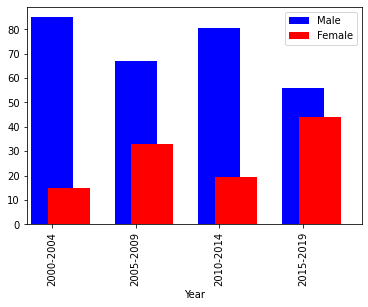

In [ ]:
axes = plt.gca()
dfx_male.plot(kind='bar', x='Year', y='Male', ax=axes, color="b");
dfx_female.plot(kind='bar', x='Year', y='Female', ax=axes, color="r",position=0.1);

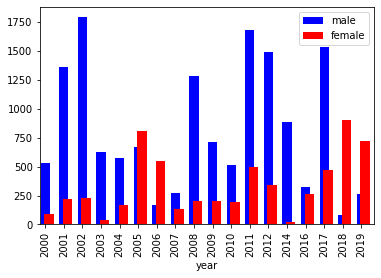

In [ ]:
axes = plt.gca()
df3.rename(columns = {'fear':'male', 'number':'female'}, inplace = True)
df3[df3['gender']=='male'].plot(kind='bar', x='year', y='male', ax=axes, color="b");
df3[df3['gender']=='female'].plot(kind='bar', x='year', y='female', ax=axes, color="r",position=0.1);

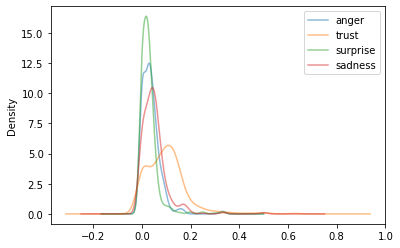

In [ ]:
df2[['anger','trust','surprise','sadness']].plot(kind="density",alpha=0.5)

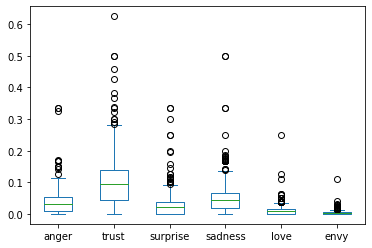

In [ ]:
df2[['anger','trust','surprise','sadness','love','envy']].plot(kind="box")

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 457 samples in 0.000s...
[t-SNE] Computed neighbors for 457 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 457 / 457
[t-SNE] Mean sigma: 0.119982
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.779587
[t-SNE] KL divergence after 300 iterations: 0.675674


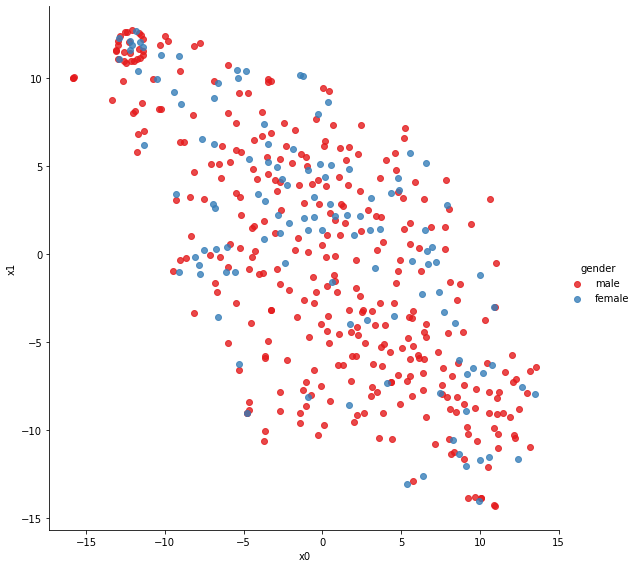

In [ ]:
visualize_clusters(df2, 2)

In [ ]:
visualize_clusters(df2, 3)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 457 samples in 0.001s...
[t-SNE] Computed neighbors for 457 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 457 / 457
[t-SNE] Mean sigma: 0.119982
[t-SNE] KL divergence after 250 iterations with early exaggeration: 111.603271
[t-SNE] KL divergence after 300 iterations: 3.167349


## Kmeans

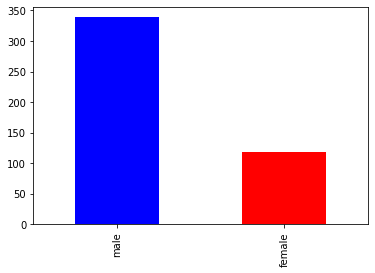

In [ ]:
# 339 male and 118 female characters
df2.gender.value_counts().plot(kind='bar',color=['b','r'])

### Elbow Method

In [ ]:
# Using elbow method to find the optimal number of clusters
Sum_of_squared_distances = []
K = range(1,50)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df2.select_dtypes(['number']).drop('number', axis=1))
    Sum_of_squared_distances.append(km.inertia_)

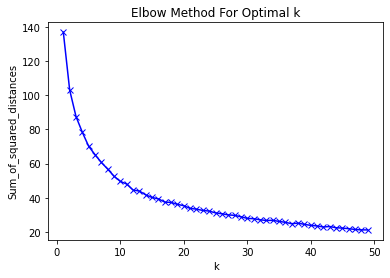

In [ ]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### clustering distribution in every cluster

In [ ]:
kmeans = KMeans(n_clusters=7, random_state=42).fit(df2.select_dtypes(['number']).drop('number', axis=1))

In [ ]:
# Assigning the label
temp = df2.copy()
temp['types_predicted'] =  kmeans.labels_

In [ ]:
# Printing the number of male and female characters in every cluster
for i in range(0, 7):
  print(temp[temp.types_predicted == i].gender.value_counts(), end='\n---------------------\n')

male      73
female    30
Name: gender, dtype: int64
---------------------
male      75
female    23
Name: gender, dtype: int64
---------------------
male      135
female     53
Name: gender, dtype: int64
---------------------
male      26
female     6
Name: gender, dtype: int64
---------------------
male      6
female    1
Name: gender, dtype: int64
---------------------
male    1
Name: gender, dtype: int64
---------------------
male      23
female     5
Name: gender, dtype: int64
---------------------


No interesting pattern was found, mainly they are being clustered as one using k means, so we should try Hiererchical or DBSCAN

## Hiererchical Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
Agg_hc = AgglomerativeClustering(n_clusters = 7, affinity = 'euclidean', linkage = 'ward')
y_hc = Agg_hc.fit_predict(df2.select_dtypes(['number']))
np.unique(y_hc, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]), array([ 68,  42,  84,  15,  47,  27, 174]))

In [ ]:
# Assigning the label
temp = df2.copy()
temp['types_predicted_agg'] =  y_hc

In [ ]:
for i in range(0, 7):
  print(temp[temp.types_predicted_agg == i].gender.value_counts(), end='\n---------------------\n')

male      57
female    11
Name: gender, dtype: int64
---------------------
male      32
female    10
Name: gender, dtype: int64
---------------------
male      67
female    17
Name: gender, dtype: int64
---------------------
male      12
female     3
Name: gender, dtype: int64
---------------------
male      37
female    10
Name: gender, dtype: int64
---------------------
male      23
female     4
Name: gender, dtype: int64
---------------------
male      111
female     63
Name: gender, dtype: int64
---------------------


# Classifying Genders

In [ ]:
from sklearn import svm
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
import pandas as pd

In [ ]:
# reading and splitting the data
df = pd.read_csv('database_with_emotions.csv')
X_train, X_test, y_train, y_test = train_test_split(df.select_dtypes(['number']), df.gender, test_size=0.30, random_state=42, stratify=df.gender)

In [ ]:
# Transforming the data using standard scaler
scaler = StandardScaler().fit(X_train) 
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [ ]:
# Hyperparameter tuning
parameters = { 
  'gamma' : [0.1, 1, 10],
  'C': [0.1, 1, 10],
  'kernel' : ['linear', 'rbf', 'poly']
}

svc = svm.SVC()
clf = GridSearchCV(svc, parameters )
clf.fit(X_scaled_train, y_train)
sorted(clf.cv_results_.keys())

In [ ]:
# Using SVM for final results
svc = svm.SVC(kernel='rbf', gamma=1).fit(X_scaled_train, y_train)   
svc.fit(X_scaled_train, y_train)

In [ ]:
print("Testing Accuracy: %.2f %%" % (accuracy_score(y_test, svc.predict(X_scaled_test)) * 100))

Testing Accuracy: 64.29 %


In [ ]:
print("Training Accuracy: %.2f %%" % (accuracy_score(y_train, svc.predict(X_scaled_train)) * 100))

Training Accuracy: 95.00 %
